# Hardware Insights Case Study

### Imports and Setup

In [170]:
# imports
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats

In [171]:
# import csvs

issues_df = pd.read_csv('dataset/issue_data.csv')
sales_df = pd.read_csv('dataset/sales_data.csv')

In [172]:
# check imported dfs
issues_df.head()

,VEHICLE_MODEL,CUSTOMER_REGION,MANUFACTURING_CITY,CUSTOMER_ISSUE,WEEK,ISSUE_COUNT
0,HL5,Americas,Detroit,Air Conditioning/Heating Issue,2022-07-03,1
1,HL5,Americas,Detroit,Air Conditioning/Heating Issue,2022-07-10,1
2,HL5,Americas,Detroit,Air Conditioning/Heating Issue,2022-07-17,1
3,HL5,Americas,Detroit,Air Conditioning/Heating Issue,2022-07-24,1
4,HL5,Americas,Detroit,Air Conditioning/Heating Issue,2022-08-14,2


In [173]:
sales_df.head()

,VEHICLE_MODEL,CUSTOMER_REGION,MANUFACTURING_CITY,VEHICLES_SOLD_COUNT
0,HL5,Americas,Detroit,61282
1,HL5,Americas,Munich,150906
2,HL5,Americas,Tokyo,922086
3,HL5,Asia,Detroit,17217
4,HL5,Asia,Munich,142913


### Checking Issues

In [174]:
# check all rows accounted for
len(issues_df)

114139

In [175]:
issues_df['VEHICLE_MODEL'].unique()

array(['HL5', 'PX8', 'VC3', 'XN7'], dtype=object)

In [176]:
issues_df['CUSTOMER_REGION'].unique()

array(['Americas', 'Asia', 'Europe'], dtype=object)

In [177]:
issues_df['MANUFACTURING_CITY'].unique()

array(['Detroit', 'Munich', 'Tokyo', 'Louisville', 'Toluca', 'Toronto'],
      dtype=object)

In [178]:
issues_df['CUSTOMER_ISSUE'].unique()

array(['Air Conditioning/Heating Issue', 'Alternator Failure',
       'Axle and Drivetrain Issue', 'Battery Failure', 'Braking Issue',
       'Cooling System Inoperative', 'Door Lock Actuator Issue',
       'Electrical System Issue', 'Emissions System Malfunction',
       'Engine Failure', 'Exhaust System Leaking', 'Fuel Leak',
       'Fuel Pump Issue', 'Horn Malfunction', 'Ignition System Failure',
       'Infotainment System Malfunction', 'Key Fob Malfunctions',
       'Paint Defects', 'Power Window Regulator Problem',
       'Rust and Corrosion', 'Software Bug', 'Starter Motor Failure',
       'Steering Component Failure', 'Suspension Issue',
       'Timing Belt/Chain Issue', 'Transmission Issue',
       'Turbocharger Failure', 'Wheel Bearings Issue',
       'Windshield Wiper Motor Failure'], dtype=object)

In [179]:
#checking for nulls
print(issues_df.isnull().sum())
print(sales_df.isnull().sum())

VEHICLE_MODEL         0
CUSTOMER_REGION       0
MANUFACTURING_CITY    0
CUSTOMER_ISSUE        0
WEEK                  0
ISSUE_COUNT           0
dtype: int64
VEHICLE_MODEL          0
CUSTOMER_REGION        0
MANUFACTURING_CITY     0
VEHICLES_SOLD_COUNT    0
dtype: int64


In [180]:
### Checking Sales

In [181]:
len(sales_df)

42

In [182]:
sales_df['VEHICLE_MODEL'].unique()

array(['HL5', 'PX8', 'VC3', 'XN7'], dtype=object)

In [183]:
sales_df['CUSTOMER_REGION'].unique()

array(['Americas', 'Asia', 'Europe'], dtype=object)

In [184]:
sales_df['MANUFACTURING_CITY'].unique()

array(['Detroit', 'Munich', 'Tokyo', 'Louisville', 'Toluca', 'Toronto'],
      dtype=object)

## Exploration things

In [185]:
### Chart - sales by region
### and then maybe stacked to add in models?
### Or like seaborn to create multiple bar charts, regions, and the charts are sales v model

In [186]:
# Bar chart of models

fig=px.bar(data_frame=sales_df,x='VEHICLE_MODEL',y='VEHICLES_SOLD_COUNT',color='CUSTOMER_REGION')
fig.show()

In [187]:
#Which manufacturing cities produce which models?
fig2=px.bar(data_frame=sales_df,x='MANUFACTURING_CITY',y='VEHICLES_SOLD_COUNT',color='VEHICLE_MODEL')
fig2.show()

In [188]:
# In order to merge things together we need to drop the week column because that doesn't exist in the sales data. So let's group by the other things

new_issues_df = issues_df.groupby(['VEHICLE_MODEL'])['ISSUE_COUNT'].sum().reset_index()
new_issues_df.head(100)

,VEHICLE_MODEL,ISSUE_COUNT
0,HL5,445249
1,PX8,568077
2,VC3,110460
3,XN7,497691


In [189]:
# Let's do the same to sales
new_sales_df = sales_df.groupby(['VEHICLE_MODEL'])['VEHICLES_SOLD_COUNT'].sum().reset_index()
new_sales_df.head(100)

,VEHICLE_MODEL,VEHICLES_SOLD_COUNT
0,HL5,4468652
1,PX8,5211195
2,VC3,3479840
3,XN7,18726583


In [190]:
# Let's merge things together
#First let's remove the time component from the issue data

merged_df = new_issues_df.merge(new_sales_df,how='left',on='VEHICLE_MODEL')
merged_df.head()

,VEHICLE_MODEL,ISSUE_COUNT,VEHICLES_SOLD_COUNT
0,HL5,445249,4468652
1,PX8,568077,5211195
2,VC3,110460,3479840
3,XN7,497691,18726583


In [191]:
merged_df['ISSUE_RATE']=merged_df['ISSUE_COUNT']/merged_df['VEHICLES_SOLD_COUNT']
merged_df.head()

,VEHICLE_MODEL,ISSUE_COUNT,VEHICLES_SOLD_COUNT,ISSUE_RATE
0,HL5,445249,4468652,0.099638
1,PX8,568077,5211195,0.109011
2,VC3,110460,3479840,0.031743
3,XN7,497691,18726583,0.026577


In [192]:
#Normalizing using z-scale

standard_scaler = StandardScaler()
merged_df['NORMALIZED_ISSUE_RATE'] = standard_scaler.fit_transform(merged_df[['ISSUE_RATE']])

print(merged_df)

  VEHICLE_MODEL  ISSUE_COUNT  VEHICLES_SOLD_COUNT  ISSUE_RATE  \
0           HL5       445249              4468652    0.099638   
1           PX8       568077              5211195    0.109011   
2           VC3       110460              3479840    0.031743   
3           XN7       497691             18726583    0.026577   

   NORMALIZED_ISSUE_RATE  
0               0.870904  
1               1.119036  
2              -0.926585  
3              -1.063355  


In [193]:
# based on above, PX8 has the most significant issue rate

## Time Series Anomaly Analysis

In [194]:
# Now let's do a time-series analysis
# We need to group issue_count by week

issues_timeseries_df = issues_df.groupby(['WEEK'])['ISSUE_COUNT'].sum().reset_index()
issues_timeseries_df.head()

,WEEK,ISSUE_COUNT
0,2021-09-19,134
1,2021-09-26,1244
2,2021-10-03,1891
3,2021-10-10,2622
4,2021-10-17,2901


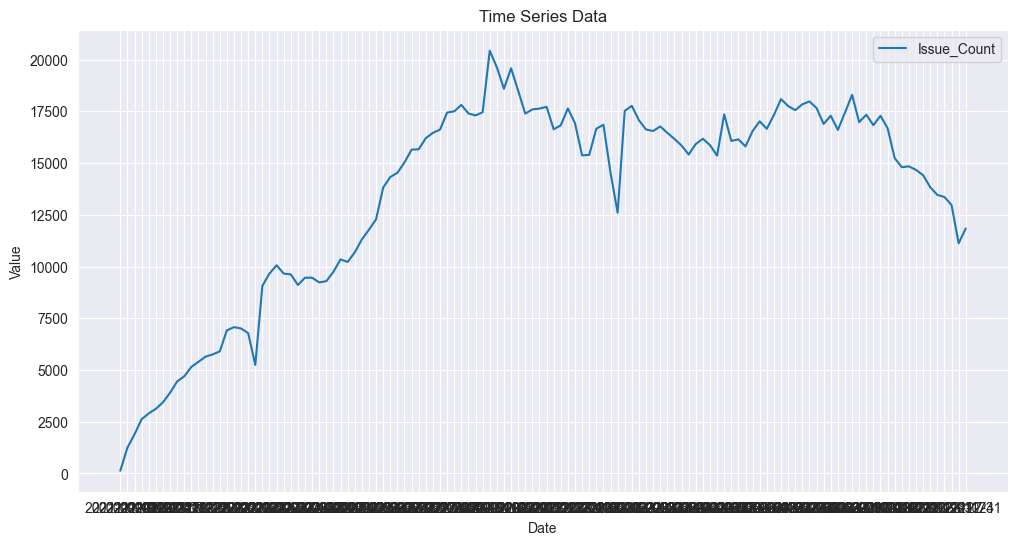

In [195]:
# Now let's do a time-series analysis
plt.figure(figsize=(12, 6))
plt.plot(issues_timeseries_df['WEEK'], issues_timeseries_df['ISSUE_COUNT'], label='Issue_Count')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [196]:
#Now let's standardize using z-scale



# Standardize the data
scaler = StandardScaler()
issues_timeseries_df['ISSUE_COUNT_SCALED'] = scaler.fit_transform(issues_timeseries_df[['ISSUE_COUNT']])


In [197]:
# Fit the Isolation Forest model
model = IsolationForest(contamination=0.1)  # Assume 10% anomalies
issues_timeseries_df['ANOMALY'] = model.fit_predict(issues_timeseries_df[['ISSUE_COUNT_SCALED']])

# Convert -1 (anomaly) and 1 (normal) to boolean
issues_timeseries_df['ANOMALY'] = issues_timeseries_df['ANOMALY'] == -1

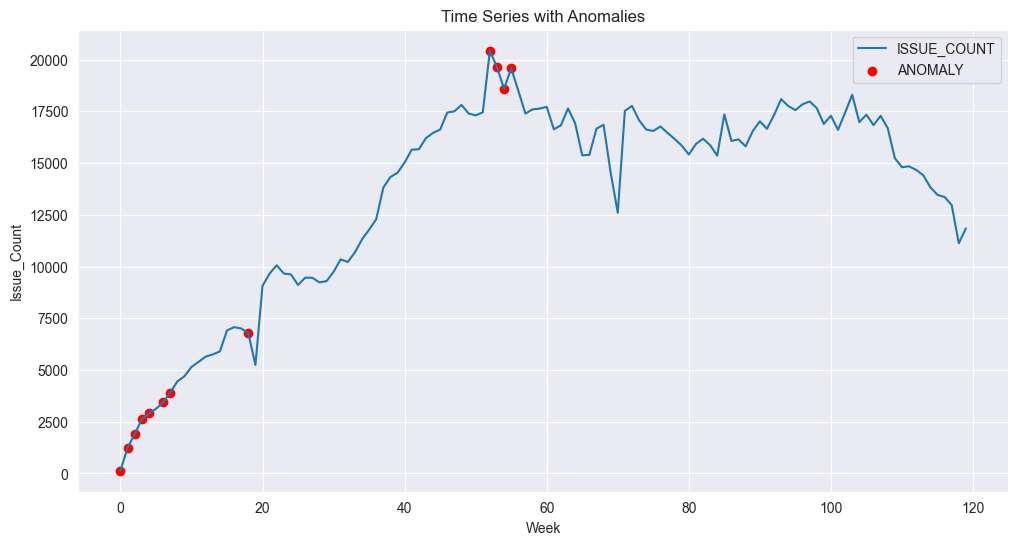

In [198]:
#Now let's plot

plt.figure(figsize=(12, 6))
plt.plot(issues_timeseries_df.index, issues_timeseries_df['ISSUE_COUNT'], label='ISSUE_COUNT')
plt.scatter(issues_timeseries_df.index[issues_timeseries_df['ANOMALY']], issues_timeseries_df['ISSUE_COUNT'][issues_timeseries_df['ANOMALY']], color='red', label='ANOMALY')
plt.title('Time Series with Anomalies')
plt.xlabel('Week')
plt.ylabel('Issue_Count')
plt.legend()
plt.show()


In [199]:
# # Using seasonal decomposition
# 
# from statsmodels.tsa.seasonal import seasonal_decompose
# 
# # Decompose the time series
# decomposition = seasonal_decompose(issues_timeseries_df['WEEK'], model='additive')
# decomposition.plot()
# plt.show()

In [200]:
#What about using a random forest?
#Well, there are some extra steps

#regenerate a clean df
# Now let's do a time-series analysis
# We need to group issue_count by week

issues_timeseries_rf_df = issues_df.groupby(['WEEK'])['ISSUE_COUNT'].sum().reset_index()
issues_timeseries_rf_df.head()

,WEEK,ISSUE_COUNT
0,2021-09-19,134
1,2021-09-26,1244
2,2021-10-03,1891
3,2021-10-10,2622
4,2021-10-17,2901


In [201]:
# Create labels for anomalies (you could use a more sophisticated method)
issues_timeseries_rf_df['label'] = 0
issues_timeseries_rf_df.loc[issues_timeseries_rf_df.index[20:25], 'label'] = 1  # Marking anomalies as 1


In [202]:
#standardize the data

scaler = StandardScaler()
issues_timeseries_rf_df['ISSUE_COUNT_SCALED'] = scaler.fit_transform(issues_timeseries_rf_df[['ISSUE_COUNT']])

In [203]:
# Features and labels
X = issues_timeseries_rf_df[['ISSUE_COUNT_SCALED']]
y = issues_timeseries_rf_df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [204]:
# train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

In [205]:
# Predict anomalies
issues_timeseries_rf_df['predicted'] = clf.predict(X)

# Evaluate the model
print(classification_report(y, issues_timeseries_rf_df['predicted']))



              precision    recall  f1-score   support

           0       0.99      0.99      0.99       115
           1       0.80      0.80      0.80         5

    accuracy                           0.98       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.98      0.98      0.98       120



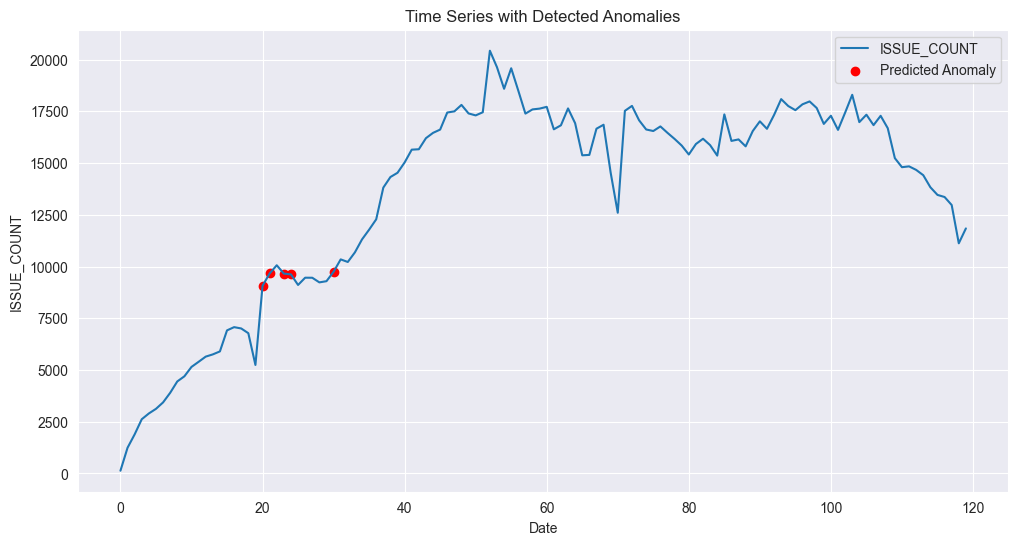

In [206]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(issues_timeseries_rf_df.index, issues_timeseries_rf_df['ISSUE_COUNT'], label='ISSUE_COUNT')
plt.scatter(issues_timeseries_rf_df.index[issues_timeseries_rf_df['predicted'] == 1], issues_timeseries_rf_df['ISSUE_COUNT'][issues_timeseries_rf_df['predicted'] == 1], color='red', label='Predicted Anomaly')
plt.title('Time Series with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('ISSUE_COUNT')
plt.legend()
plt.show()

## Outlier Detection

In [207]:
# Step 1 - remove the time component and bring everything in

issues_notime_df = issues_df.groupby(['VEHICLE_MODEL','CUSTOMER_REGION','MANUFACTURING_CITY','CUSTOMER_ISSUE'])['ISSUE_COUNT'].sum().reset_index()

In [208]:
issues_notime_df.head()

,VEHICLE_MODEL,CUSTOMER_REGION,MANUFACTURING_CITY,CUSTOMER_ISSUE,ISSUE_COUNT
0,HL5,Americas,Detroit,Air Conditioning/Heating Issue,235
1,HL5,Americas,Detroit,Alternator Failure,208
2,HL5,Americas,Detroit,Axle and Drivetrain Issue,370
3,HL5,Americas,Detroit,Battery Failure,209
4,HL5,Americas,Detroit,Braking Issue,255


In [209]:
# Calculate overall defect counts by characteristics
total_issues_by_city = issues_notime_df.groupby('MANUFACTURING_CITY')['ISSUE_COUNT'].sum()
total_issues_by_model = issues_notime_df.groupby('VEHICLE_MODEL')['ISSUE_COUNT'].sum()
total_issues_by_region = issues_notime_df.groupby('CUSTOMER_REGION')['ISSUE_COUNT'].sum()


In [210]:
#Finding outliers

# Z-score for detecting outliers
issues_notime_df['Z-score'] = stats.zscore(issues_notime_df['ISSUE_COUNT'])
outliers_z_score = issues_notime_df[issues_notime_df['Z-score'].abs() > 3]  # Z-score threshold

# IQR for detecting outliers
Q1 = issues_notime_df['ISSUE_COUNT'].quantile(0.25)
Q3 = issues_notime_df['ISSUE_COUNT'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = issues_notime_df[(issues_notime_df['ISSUE_COUNT'] < (Q1 - 1.5 * IQR)) | (issues_notime_df['ISSUE_COUNT'] > (Q3 + 1.5 * IQR))]


In [211]:
#Need to normalize

scaler = StandardScaler()
issues_notime_df['ISSUE_COUNT_NORMALIZED'] = scaler.fit_transform(issues_notime_df[['ISSUE_COUNT']])


In [212]:
issues_notime_df.head()

,VEHICLE_MODEL,CUSTOMER_REGION,MANUFACTURING_CITY,CUSTOMER_ISSUE,ISSUE_COUNT,Z-score,ISSUE_COUNT_NORMALIZED
0,HL5,Americas,Detroit,Air Conditioning/Heating Issue,235,-0.309836,-0.309836
1,HL5,Americas,Detroit,Alternator Failure,208,-0.317620,-0.317620
2,HL5,Americas,Detroit,Axle and Drivetrain Issue,370,-0.270917,-0.270917
3,HL5,Americas,Detroit,Battery Failure,209,-0.317331,-0.317331
4,HL5,Americas,Detroit,Braking Issue,255,-0.304070,-0.304070


In [213]:
#Calcluate impact ratio
# Impact ratio: defect count relative to total count
total_issues = issues_notime_df['ISSUE_COUNT'].sum()
issues_notime_df['IMPACT_RATIO'] = issues_notime_df['ISSUE_COUNT'] / total_issues


In [214]:
#Summary results

# Combine absolute and relative measures
impact_summary = pd.DataFrame({
    'Total Issues by City': total_issues_by_city,
    'Total Issues by Model': total_issues_by_model,
    'Total Issues by Region': total_issues_by_region,
    'Impact Ratio': issues_notime_df.groupby('MANUFACTURING_CITY')['IMPACT_RATIO'].mean()
})

# Rank characteristics by total defects and impact ratio
top_cities = total_issues_by_city.sort_values(ascending=False).head(10)
top_models = total_issues_by_model.sort_values(ascending=False).head(10)
top_regions = total_issues_by_region.sort_values(ascending=False).head(10)

print("Top Manufacturing Cities by Issues:\n", top_cities)
print("Top Vehicle Models by Issues:\n", top_models)
print("Top Customer Regions by Issues:\n", top_regions)


Top Manufacturing Cities by Issues:
 MANUFACTURING_CITY
Tokyo         772631
Munich        362569
Louisville    339053
Detroit       104835
Toronto        36472
Toluca          5917
Name: ISSUE_COUNT, dtype: int64
Top Vehicle Models by Issues:
 VEHICLE_MODEL
PX8    568077
XN7    497691
HL5    445249
VC3    110460
Name: ISSUE_COUNT, dtype: int64
Top Customer Regions by Issues:
 CUSTOMER_REGION
Europe      900618
Americas    384015
Asia        336844
Name: ISSUE_COUNT, dtype: int64


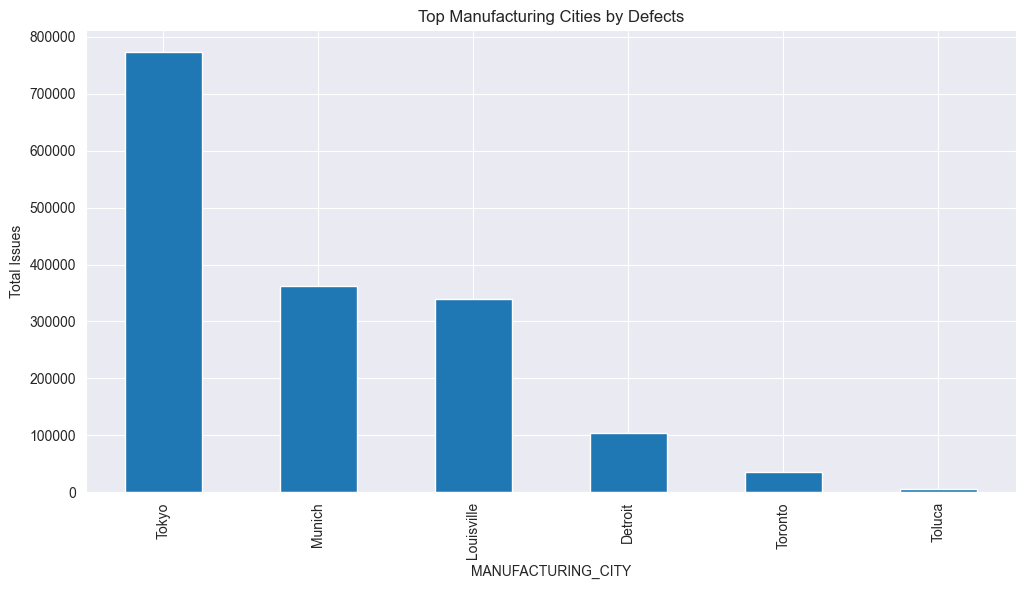

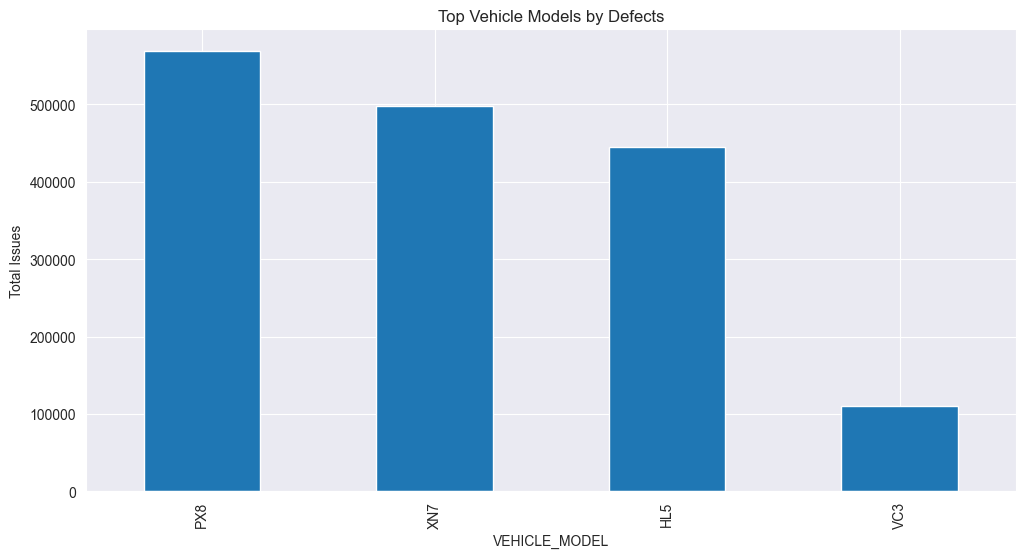

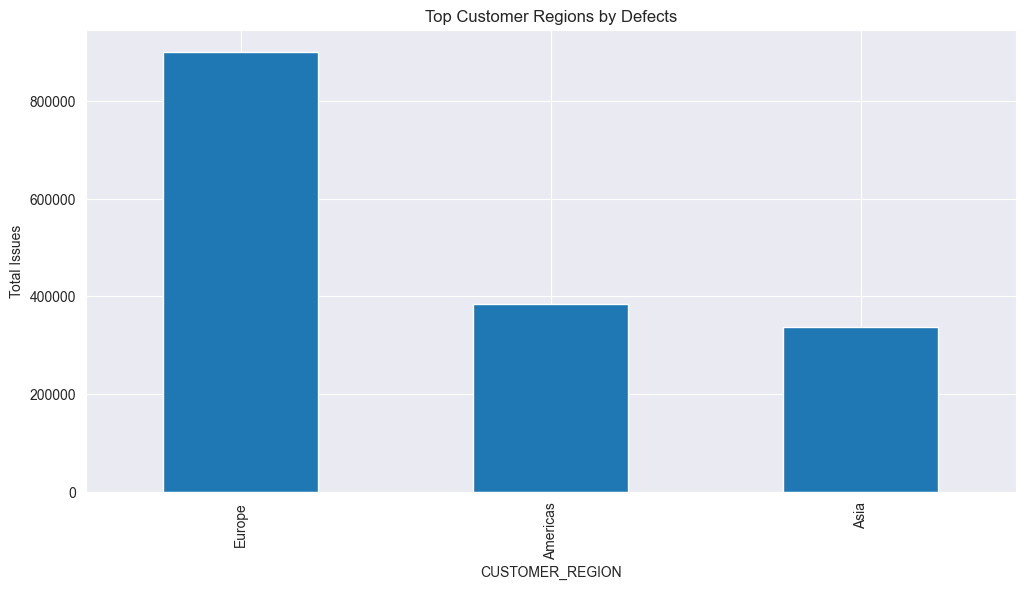

In [215]:
#Let's visualize it

#Total issues by city
plt.figure(figsize=(12, 6))
top_cities.plot(kind='bar', title='Top Manufacturing Cities by Defects')
plt.ylabel('Total Issues')
plt.show()

# Total issues by model
plt.figure(figsize=(12, 6))
top_models.plot(kind='bar', title='Top Vehicle Models by Defects')
plt.ylabel('Total Issues')
plt.show()

# Total issues by region
plt.figure(figsize=(12, 6))
top_regions.plot(kind='bar', title='Top Customer Regions by Defects')
plt.ylabel('Total Issues')
plt.show()

In [216]:
# Aggregate issue data to get total issues per combination of vehicle model, region, and manufacturing city
issues_agg = issues_df.groupby(['VEHICLE_MODEL', 'CUSTOMER_REGION', 'MANUFACTURING_CITY']).agg(
    TOTAL_ISSUES=('ISSUE_COUNT', 'sum')).reset_index()

# Merge with sales data to calculate issue rates
merged_df = pd.merge(issues_agg, sales_df, on=['VEHICLE_MODEL', 'CUSTOMER_REGION', 'MANUFACTURING_CITY'])

# Calculate issue rates
merged_df['ISSUE_RATE'] = merged_df['TOTAL_ISSUES'] / merged_df['VEHICLES_SOLD_COUNT']

# Z-Score calculation for TOTAL_ISSUES and ISSUE_RATE
merged_df['Z_SCORE_ISSUES'] = stats.zscore(merged_df['TOTAL_ISSUES'])
merged_df['Z_SCORE_RATE'] = stats.zscore(merged_df['ISSUE_RATE'])

# Define the threshold for outliers (Z-scores greater than 3 or less than -3)
issue_outliers = merged_df[(merged_df['Z_SCORE_ISSUES'].abs() > 3)]
rate_outliers = merged_df[(merged_df['Z_SCORE_RATE'].abs() > 3)]

# IQR Method for ISSUE_RATE
Q1 = merged_df['ISSUE_RATE'].quantile(0.25)
Q3 = merged_df['ISSUE_RATE'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers using IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = merged_df[(merged_df['ISSUE_RATE'] < lower_bound) | (merged_df['ISSUE_RATE'] > upper_bound)]

# Display the outliers identified by Z-score and IQR methods
print(issue_outliers) 
print(rate_outliers)
print(iqr_outliers)


  VEHICLE_MODEL CUSTOMER_REGION MANUFACTURING_CITY  TOTAL_ISSUES  \
8           HL5          Europe              Tokyo        218840   

   VEHICLES_SOLD_COUNT  ISSUE_RATE  Z_SCORE_ISSUES  Z_SCORE_RATE  
8              2104376    0.103993        4.056901      0.130134  
Empty DataFrame
Columns: [VEHICLE_MODEL, CUSTOMER_REGION, MANUFACTURING_CITY, TOTAL_ISSUES, VEHICLES_SOLD_COUNT, ISSUE_RATE, Z_SCORE_ISSUES, Z_SCORE_RATE]
Index: []
  VEHICLE_MODEL CUSTOMER_REGION MANUFACTURING_CITY  TOTAL_ISSUES  \
3           HL5            Asia            Detroit          5065   
6           HL5          Europe            Detroit          5834   

   VEHICLES_SOLD_COUNT  ISSUE_RATE  Z_SCORE_ISSUES  Z_SCORE_RATE  
3                17217    0.294186       -0.754971      2.662736  
6                20340    0.286824       -0.737661      2.564705  


In [217]:
# Playing around with k-means

# One-hot encode categorical variables
merged_df_encoded = pd.get_dummies(merged_df[['VEHICLE_MODEL', 'CUSTOMER_REGION', 'MANUFACTURING_CITY']])

# Add numerical columns to the encoded data
merged_df_encoded['TOTAL_ISSUES'] = merged_df['TOTAL_ISSUES']
merged_df_encoded['ISSUE_RATE'] = merged_df['ISSUE_RATE']

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df_encoded)

In [218]:
# Apply k-means with 3 clusters (adjust based on your data)
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['CLUSTER'] = kmeans.fit_predict(scaled_data)

In [219]:
# Calculate the distance of each point from the closest cluster centroid
distances = np.min(kmeans.transform(scaled_data), axis=1)

# Define outliers as those with distances beyond the 95th percentile
threshold = np.percentile(distances, 95)
outliers = merged_df[distances > threshold]

# Display outliers
print(outliers)

   VEHICLE_MODEL CUSTOMER_REGION MANUFACTURING_CITY  TOTAL_ISSUES  \
31           XN7        Americas             Toluca          5882   
32           XN7        Americas            Toronto          3578   
37           XN7            Asia            Toronto         32894   

    VEHICLES_SOLD_COUNT  ISSUE_RATE  Z_SCORE_ISSUES  Z_SCORE_RATE  CLUSTER  
31               368430    0.015965       -0.736581     -1.042040        1  
32               182371    0.019619       -0.788442     -0.993379        1  
37              1001816    0.032834       -0.128566     -0.817409        1  


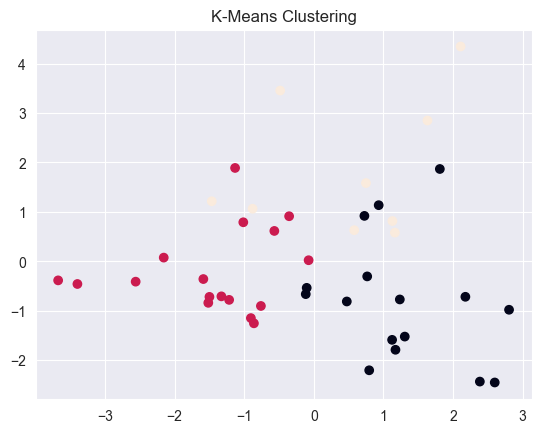

In [220]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=merged_df['CLUSTER'])
plt.title('K-Means Clustering')
plt.show()

In [221]:
### Issues by model, by manufacturing city, by issue category

In [222]:
#IF I WAS AN EXECUTIVE

# what is our overall issue rate? what percentage of vehicles have an issue?
# for those that have an issue, is it all the same/ a few components? and/or can they be traced to a certain factory?
# what about by model? are some worse than others? Is there a design issue, either causing problems in manufacturing (can check with QC?) or usage?
# what about vehicles made in one area but shipped to another - issues in shipping?
# failure rate by model
# issue rate by factory


#no SN so can't assume each issue is a distinct vehicle, some may have multiple